In [432]:
import numpy as np
import pandas as pd
from scipy.stats import iqr
from sklearn.neural_network import MLPClassifier
from keras.layers import Input,LSTM,Embedding,Dense,Dropout,Activation
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras import backend as K

### Data Genertion

In [285]:
r_x = 3 #Number of features
r_e = 1 #Error
r_xe = r_x+r_e #Total Features + Error
r_z = (10,8) #Neurons in layers for actual neural network
r_ez = (10,10) #Estimated
r_y = 3 #3 output labels
n = 10000

In [286]:
choose = lambda x,y: int(np.product(np.arange(x,x-y,-1))/np.product(np.arange(1,y+1)))
bind = lambda *x: np.hstack(x) 
relu = lambda x: np.maximum(x,0)
softmax = lambda x: np.divide(np.exp(x),np.exp(x).sum(1).reshape(-1,1))

### xe

In [287]:
xe = np.random.normal(size=(n,r_xe)) # 10000x4 feature matrix, 4 features
xe.shape

(10000, 4)

In [288]:
xe

array([[-0.45668261, -0.21703679,  0.48942661,  0.85064359],
       [-0.94345834, -1.04551665,  1.44018742, -0.15155096],
       [-0.2816422 , -0.87223675,  0.7819262 ,  0.60334051],
       ...,
       [ 0.24879436,  1.32912337,  0.52477422, -0.93833559],
       [ 1.02895715,  1.38445413,  1.74182906, -0.60333744],
       [-1.13444152, -0.2818362 ,  0.56233903, -0.35400789]])

### w

In [289]:
w = np.ones((1,2))
w

array([[1., 1.]])

In [290]:
for i in range(2,r_xe):
    w = bind(bind(np.ones((i,1)),np.eye(i)).T,\
             bind(np.zeros((w.shape[0],1)),w).T).T
w

array([[1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 1.]])

In [291]:
for i in range(w.shape[0]): #All rows with last element 1 are updated to whole row being 0
    if w[i,-r_e:].sum() != 0 and w[i,:r_x].sum() != 0: #Sum of last el and first 3 els spearately
        w[i,:] = 0
w

array([[1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### z

In [292]:
z = np.random.normal(size=(n,choose(r_xe,2))) # 1000 x 6 matrix

In [293]:
z

array([[-2.13237132,  0.36593609, -1.59203337,  0.87512652,  0.16608796,
         0.73692542],
       [-0.57439561, -0.2288291 , -0.22282841,  1.49774058,  0.22444343,
        -1.03593993],
       [ 0.21720855, -0.551104  ,  0.6850578 , -0.11678826,  0.61008161,
         1.15344902],
       ...,
       [ 0.59724505,  1.15591501,  0.40412344,  0.23175334,  0.05658648,
         1.22541528],
       [-1.74747025,  2.12358772, -1.15974859,  1.06932809,  0.1936857 ,
        -0.02469766],
       [ 0.67476826, -0.72839106,  0.5834144 , -0.60311529,  0.28665373,
        -0.30588218]])

### z@w

In [294]:
print('z = {0}\n'.format(z)) # 10000 x 6
print('w = {0}\n'.format(w)) # 6 x 4
print(z@w) # 10000 x 4, error
print((z@w).shape)

z = [[-2.13237132  0.36593609 -1.59203337  0.87512652  0.16608796  0.73692542]
 [-0.57439561 -0.2288291  -0.22282841  1.49774058  0.22444343 -1.03593993]
 [ 0.21720855 -0.551104    0.6850578  -0.11678826  0.61008161  1.15344902]
 ...
 [ 0.59724505  1.15591501  0.40412344  0.23175334  0.05658648  1.22541528]
 [-1.74747025  2.12358772 -1.15974859  1.06932809  0.1936857  -0.02469766]
 [ 0.67476826 -0.72839106  0.5834144  -0.60311529  0.28665373 -0.30588218]]

w = [[1. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

[[-1.76643523 -1.2572448   1.24106262  0.        ]
 [-0.80322472  0.92334497  1.26891148  0.        ]
 [-0.33389545  0.10042028 -0.66789226  0.        ]
 ...
 [ 1.75316006  0.82899839  1.38766835  0.        ]
 [ 0.37611747 -0.67814216  3.19291581  0.        ]
 [-0.05362281  0.07165297 -1.33150635  0.        ]]
(10000, 4)


### Feature Sapce

In [295]:
xe = xe + z@w #Feature space with error

### Neural Net

In [296]:
while True:
    wmat = [] #Weights matrix for all neurons of all layers
    layers = [] #All layers in the neural net
    last = xe #Last layer reference
    for i in range(len(r_z)): #r_z has all the layers and r_z[i] has value of number of neurons the layers has
        #Dense layers
        w_tmp = np.random.uniform(size=(last.shape[1]+1,r_z[i]))*3-1 #weight matrix for current layer
        last = relu(bind(ones,last)@w_tmp) #adding intercept neuron and finding the output for propagation
        wmat += [w_tmp] #adding all the neuron weights as arrays
        layers += [last] #last layer
    w_tmp = np.random.uniform(size=(last.shape[1]+1,r_y))*3-1 #final layer
    last = relu(bind(ones,last)@w_tmp) #relu
    wmat += [w_tmp] #adding wtemp wghts
    layers += [last] #adding last layer
    y = softmax(last).argmax(axis=1) #activation function for labels
    (values,counts) = np.unique(y,return_counts=True) #count of values for each label
    if values.shape[0] == 3 and counts.min()>0.1*n: break #if all labels have minimum 10% values then break else keep on doing
np.unique(y,return_counts=True)

(array([0, 1, 2], dtype=int64), array([1663, 1368, 6969], dtype=int64))

### Predictions on training data

In [297]:
def mypred(x):
    last = x.copy()
    ones = np.ones((x.shape[0],1)) #Feature with all values 1
    for i in range(len(wmat)):
        w_tmp = wmat[i]
        last = relu(bind(ones,last)@w_tmp)
    return softmax(last)

In [298]:
softmax(mypred(bind(xe[:,:r_x],np.zeros((n,1)))))

array([[0.22172367, 0.52253235, 0.25574398],
       [0.21430996, 0.56454211, 0.22114792],
       [0.21194875, 0.21194757, 0.57610368],
       ...,
       [0.21195572, 0.21199463, 0.57604964],
       [0.21194156, 0.57611688, 0.21194156],
       [0.24804831, 0.22028099, 0.5316707 ]])

In [299]:
predictions=softmax(mypred(bind(xe[:,:r_x],np.zeros((n,1))))).argmax(axis=1)

### Training accuracy

In [300]:
cor = 0
for i in range(len(predictions)):
    if predictions[i]==y[i]:
        cor+=1
print(cor/len(predictions))

0.8044


### Gradients

In [301]:
dx = iqr(xe,axis=0)/10000 #For each feature array

In [302]:
dx

array([0.00023484, 0.00023315, 0.00023426, 0.00013385])

#### Gradient of NN

In [539]:
def gradient2(model):
    x=trainX
    dydx = []
    for i in range(r_x): 
        x_tmp = x.copy()
        x_tmp[:,i] += dx[i]
        y0 = np.array(layer_out(x,model))
        y0 = y0[0]
        y1 = np.array(layer_out(x_tmp,model))
        y1 = y1[0]
        y0 /= y0.max(axis=1).reshape(-1,1)
        y1 /= y1.max(axis=1).reshape(-1,1)
        dy = y1-y0
        dydx += [(dy/dx[i]).mean(axis=0)]
    dydx = np.array(dydx)
    return dydx

In [540]:
def layer_out(df,model):
    inp = model.input
    outp = [layer.output for layer in model.layers]
    functors = [K.function([inp, K.learning_phase()], [out]) for out in outp]
    layer_outs = [func([df,1]) for func in functors]
    return layer_outs[-2]

### Train test split

In [373]:
trainX,valX,trainY,valY = train_test_split(xe,y,test_size=0.2)

### TF NN

In [476]:
clf1 = Sequential()
clf1.add(Dense(10,input_shape=(4,)))
clf1.add(Dense(8,input_shape=(10,),activation='relu'))
clf1.add(Dense(3,input_shape=(8,),activation='softmax'))
clf1.add(Dense(1))
clf1.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
clf1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_62 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_63 (Dense)             (None, 3)                 27        
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 4         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [477]:
clf2 = Sequential()
clf2.add(Dense(10,input_shape=(4,)))
clf2.add(Dense(10,input_shape=(10,),activation='relu'))
clf2.add(Dense(8,input_shape=(10,),activation='relu'))
clf2.add(Dense(3,input_shape=(8,),activation='softmax'))
clf2.add(Dense(1))
clf2.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
clf2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_66 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_67 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_68 (Dense)             (None, 3)                 27        
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 4         
Total params: 279
Trainable params: 279
Non-trainable params: 0
_________________________________________________________________


In [478]:
clf3 = Sequential()
clf3.add(Dense(10,input_shape=(4,)))
clf3.add(Dense(10,input_shape=(10,)))
clf3.add(Dense(8,input_shape=(10,)))
clf3.add(Dense(8,input_shape=(8,),activation='relu'))
clf3.add(Dense(3,input_shape=(8,),activation='softmax'))
clf3.add(Dense(1))
clf3.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
clf3.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_71 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_72 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_73 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_74 (Dense)             (None, 3)                 27        
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 4         
Total params: 351
Trainable params: 351
Non-trainable params: 0
_______________________________________________________

### Training

In [479]:
clf = [clf1,clf2,clf3]

In [543]:
def train(clf,trainX,trainY,valX,valY):
    models = []
    for classifier in clf:
        model = classifier.fit(trainX,trainY,epochs=100)
        models += [model]
        grad = gradient2(classifier)
        print(grad)
        predictions = classifier.predict(valX)
        predictions = [int(predictions[i]) for i in range(len(predictions))]
        accuracy = np.array(predictions==valY).sum()/len(valY)
        print(accuracy)
    return models

In [544]:
models = train(clf,trainX,trainY,valX,valY)

Epoch 1/100
8000/8000 [==============================] - 0s 57us/step - loss: 0.1386 - accuracy: 0.8364
Epoch 2/100
8000/8000 [==============================] - 1s 114us/step - loss: 0.1381 - accuracy: 0.8359
Epoch 3/100
8000/8000 [==============================] - 1s 122us/step - loss: 0.1382 - accuracy: 0.8349
Epoch 4/100
8000/8000 [==============================] - 1s 126us/step - loss: 0.1376 - accuracy: 0.8364
Epoch 5/100
8000/8000 [==============================] - 1s 112us/step - loss: 0.1376 - accuracy: 0.8353
Epoch 6/100
8000/8000 [==============================] - 1s 91us/step - loss: 0.1368 - accuracy: 0.8361
Epoch 7/100
8000/8000 [==============================] - 1s 122us/step - loss: 0.1367 - accuracy: 0.8360
Epoch 8/100
8000/8000 [==============================] - 1s 122us/step - loss: 0.1363 - accuracy: 0.8385
Epoch 9/100
8000/8000 [==============================] - 1s 123us/step - loss: 0.1353 - accuracy: 0.8395
Epoch 10/100
8000/8000 [==============================] -

8000/8000 [==============================] - 1s 121us/step - loss: 0.0556 - accuracy: 0.9388
Epoch 79/100
8000/8000 [==============================] - 1s 106us/step - loss: 0.0554 - accuracy: 0.9436
Epoch 80/100
8000/8000 [==============================] - 1s 92us/step - loss: 0.0560 - accuracy: 0.9405
Epoch 81/100
8000/8000 [==============================] - 1s 102us/step - loss: 0.0550 - accuracy: 0.9424
Epoch 82/100
8000/8000 [==============================] - 1s 101us/step - loss: 0.0546 - accuracy: 0.9411
Epoch 83/100
8000/8000 [==============================] - 1s 101us/step - loss: 0.0553 - accuracy: 0.9431
Epoch 84/100
8000/8000 [==============================] - 1s 104us/step - loss: 0.0547 - accuracy: 0.9438
Epoch 85/100
8000/8000 [==============================] - 1s 102us/step - loss: 0.0545 - accuracy: 0.9427
Epoch 86/100
8000/8000 [==============================] - 1s 100us/step - loss: 0.0543 - accuracy: 0.9427
Epoch 87/100
8000/8000 [==============================] - 1s

8000/8000 [==============================] - 1s 87us/step - loss: 0.0398 - accuracy: 0.9615
Epoch 55/100
8000/8000 [==============================] - 1s 97us/step - loss: 0.0415 - accuracy: 0.9600
Epoch 56/100
8000/8000 [==============================] - 1s 105us/step - loss: 0.0407 - accuracy: 0.9603
Epoch 57/100
8000/8000 [==============================] - 1s 108us/step - loss: 0.0403 - accuracy: 0.9592
Epoch 58/100
8000/8000 [==============================] - 1s 106us/step - loss: 0.0385 - accuracy: 0.9630
Epoch 59/100
8000/8000 [==============================] - 1s 110us/step - loss: 0.0395 - accuracy: 0.9599
Epoch 60/100
8000/8000 [==============================] - 1s 113us/step - loss: 0.0377 - accuracy: 0.9625
Epoch 61/100
8000/8000 [==============================] - 1s 76us/step - loss: 0.0386 - accuracy: 0.9615
Epoch 62/100
8000/8000 [==============================] - 1s 105us/step - loss: 0.0386 - accuracy: 0.9615
Epoch 63/100
8000/8000 [==============================] - 1s 1

8000/8000 [==============================] - 1s 113us/step - loss: 0.1478 - accuracy: 0.8346
Epoch 31/100
8000/8000 [==============================] - 1s 112us/step - loss: 0.1463 - accuracy: 0.8339
Epoch 32/100
8000/8000 [==============================] - 1s 90us/step - loss: 0.1425 - accuracy: 0.8381
Epoch 33/100
8000/8000 [==============================] - 1s 113us/step - loss: 0.1438 - accuracy: 0.8375
Epoch 34/100
8000/8000 [==============================] - 1s 111us/step - loss: 0.1395 - accuracy: 0.8411
Epoch 35/100
8000/8000 [==============================] - 1s 112us/step - loss: 0.1407 - accuracy: 0.8446
Epoch 36/100
8000/8000 [==============================] - 1s 113us/step - loss: 0.1364 - accuracy: 0.8471
Epoch 37/100
8000/8000 [==============================] - 1s 114us/step - loss: 0.1319 - accuracy: 0.8555
Epoch 38/100
8000/8000 [==============================] - 1s 103us/step - loss: 0.1231 - accuracy: 0.8656
Epoch 39/100
8000/8000 [==============================] - 1s

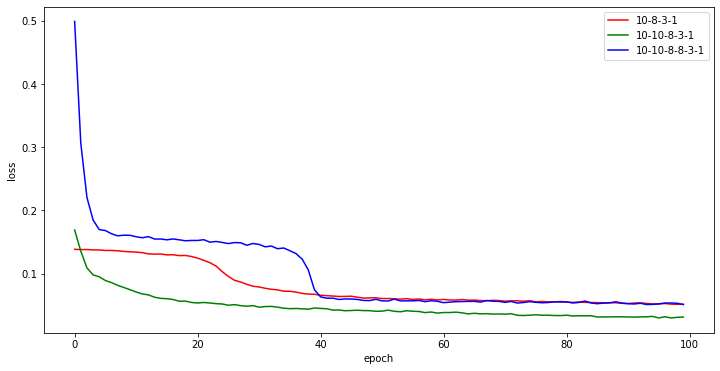

In [565]:
color = ['r','g','b']
labels = ["10-8-3-1","10-10-8-3-1","10-10-8-8-3-1"]
plt.figure(figsize=(12, 6))
for i in range(len(models)):
    plt.plot(models[i].history['loss'],c=color[i],label=labels[i])
plt.ylabel("loss")
plt.xlabel("epoch")
leg = plt.legend()
plt.show()

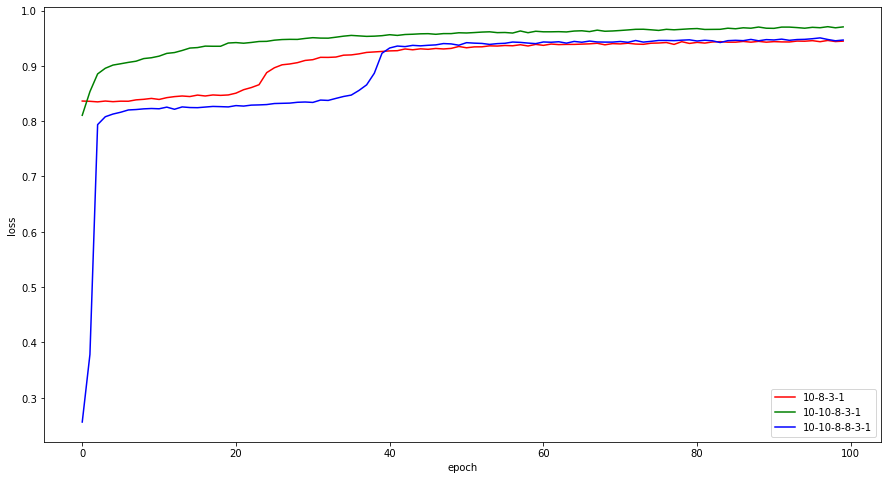

In [566]:
color = ['r','g','b']
labels = ["10-8-3-1","10-10-8-3-1","10-10-8-8-3-1"]
plt.figure(figsize=(15, 8))
for i in range(len(models)):
    plt.plot(models[i].history['accuracy'],c=color[i],label=labels[i])
plt.ylabel("loss")
plt.xlabel("epoch")
leg = plt.legend()
plt.show()